In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler  # Import for scaling features
from tensorflow.keras.utils import to_categorical  # Import for one-hot encoding
from google.colab import drive  # Import for Google Drive integration

# Mount Google Drive
drive.mount('/content/drive')

# Path to the cleaned dataset
file_path = "/content/drive/MyDrive/Final Project/data/US_Accidents_Sample.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Confirm successful load
print("Dataset Sample:")
print(df.head())

# Check dataset info
print("\nDataset Info:")
print(df.info())

# Check class distribution
print("\nClass Distribution:")
print(df['Severity'].value_counts())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Sample:
   Severity  Start_Time    End_Time  Start_Lat  Start_Lng  End_Lat  End_Lng  \
0         3  1454910360  1454929200  39.865147 -84.058723  -9999.0  -9999.0   
1         2  1454911679  1454913479  39.928059 -82.831184  -9999.0  -9999.0   
2         2  1454914167  1454915967  39.063148 -84.032608  -9999.0  -9999.0   
3         3  1454916214  1454918014  39.747753 -84.205582  -9999.0  -9999.0   
4         2  1454917147  1454918947  39.627781 -84.188354  -9999.0  -9999.0   

   Distance(mi)  Weather_Timestamp  Temperature(F)  ...  \
0          0.01         1454911080            36.9  ...   
1          0.01         1454910660            37.9  ...   
2          0.01         1454914560            36.0  ...   
3          0.01         1454917080            35.1  ...   
4          0.01         1454917980            36.0  ...   

   Wind_Chill(F)_Missing 

# Data Pre-Processing

In [3]:
# Shuffle and split the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle rows

# Split into training (80%) and validation (20%) sets
train_size = int(0.8 * len(df))
train_df = df[:train_size]
val_df = df[train_size:]

# Separate features and target
X_train = train_df.drop(columns=['Severity'])  # Features
y_train_raw = train_df['Severity']  # Target (raw labels)
X_val = val_df.drop(columns=['Severity'])
y_val_raw = val_df['Severity']

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# One-hot encode the target variable
y_train = to_categorical(y_train_raw - 1, num_classes=4)
y_val = to_categorical(y_val_raw - 1, num_classes=4)


# Feature Importance

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5544 - loss: 1.0374 - val_accuracy: 0.5880 - val_loss: 0.6927
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5824 - loss: 0.6968 - val_accuracy: 0.5880 - val_loss: 0.7019
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5946 - loss: 0.6908 - val_accuracy: 0.5420 - val_loss: 0.6929
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5812 - loss: 0.6896 - val_accuracy: 0.5880 - val_loss: 0.6847
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5975 - loss: 0.6904 - val_accuracy: 0.5880 - val_loss: 0.6873
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5906 - loss: 0.6901 - val_accuracy: 0.5880 - val_loss: 0.6829
Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5384 - loss: 1.1029 - val_accuracy: 0.5880 - val_loss: 0.6850
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5802 - loss: 0.6958 - val_accuracy: 0.5880

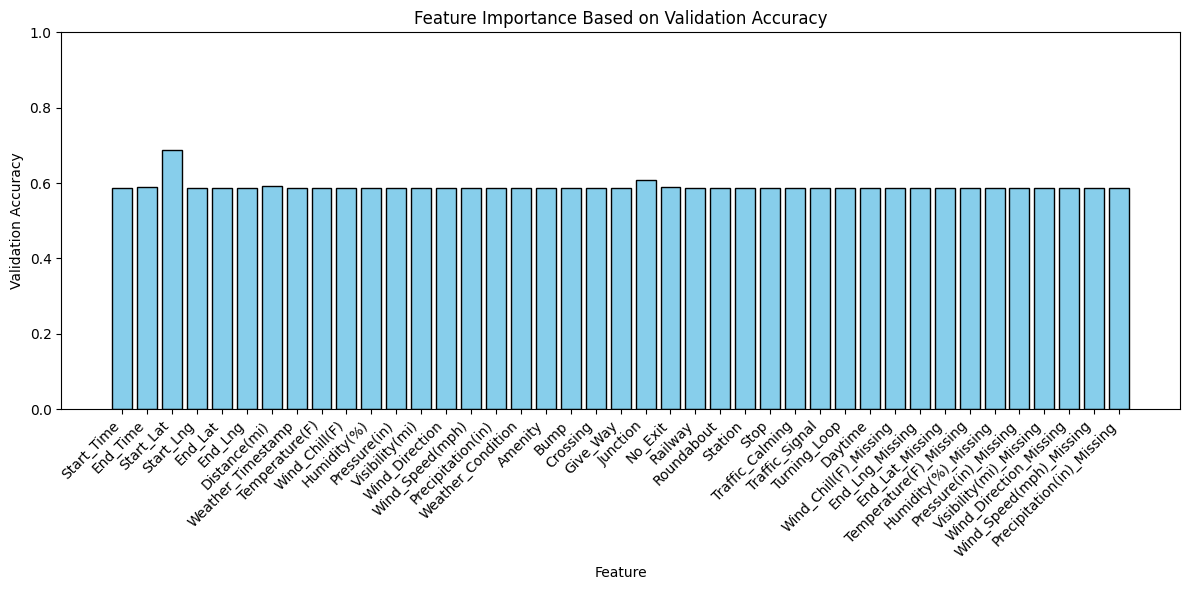

Most important feature: Start_Lat
Least important feature: Precipitation(in)_Missing


In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Train models using only one feature at a time
feature_importance = {}

# Loop through all features
for i, feature in enumerate(train_df.drop(columns=['Severity']).columns):
    # Select a single feature
    X_train_single = X_train[:, i].reshape(-1, 1)  # Use the scaled feature
    X_val_single = X_val[:, i].reshape(-1, 1)

    # Define the model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(1,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(4, activation='softmax')  # Output layer
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model with checkpointing and early stopping
    checkpoint = ModelCheckpoint(f"model_{feature}.keras", save_best_only=True, monitor='val_accuracy', mode='max')
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train_single, y_train,
        epochs=100,
        validation_data=(X_val_single, y_val),
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )

    # Save the highest validation accuracy for this feature
    feature_importance[feature] = max(history.history['val_accuracy'])

# Plot the validation accuracies as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(feature_importance.keys(), feature_importance.values(), color='skyblue', edgecolor='black')
plt.title("Feature Importance Based on Validation Accuracy")
plt.ylabel("Validation Accuracy")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')

# Dynamically set y-axis limits
if all(v > 0.8 for v in feature_importance.values()):
    plt.ylim(0.8, 1.0)
else:
    plt.ylim(0, 1.0)

plt.tight_layout()
plt.show()

# Identify the most and least important features
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
most_important = sorted_features[0][0]
least_important = sorted_features[-1][0]
print(f"Most important feature: {most_important}")
print(f"Least important feature: {least_important}")


# Remove Features Iteratively

In [9]:
# Step 2: Iterative Feature Removal
remaining_features = list(train_df.drop(columns=['Severity']).columns)  # All features except target
removed_features = []
iterative_accuracies = []  # Track validation accuracies for each iteration

while remaining_features:
    print(f"Training with features: {remaining_features}")

    # Subset the training and validation data
    X_train_subset = train_df[remaining_features].values
    X_val_subset = val_df[remaining_features].values

    # Normalize the data
    scaler = StandardScaler()
    X_train_subset = scaler.fit_transform(X_train_subset)
    X_val_subset = scaler.transform(X_val_subset)

    # Define the model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(len(remaining_features),)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(4, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model_save_path = "/content/drive/MyDrive/Final Project/Models/model_subset_" + str(len(remaining_features)) + ".keras"
    checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_accuracy', mode='max')
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_subset, y_train,
        epochs=100,
        validation_data=(X_val_subset, y_val),
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )

    # Record the best validation accuracy
    iterative_accuracies.append(max(history.history['val_accuracy']))

    # Remove the least important feature
    removed_features.append(remaining_features.pop())
    print(f"Removed feature: {removed_features[-1]}")


Training with features: ['Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Daytime', 'Wind_Chill(F)_Missing', 'End_Lng_Missing', 'End_Lat_Missing', 'Temperature(F)_Missing', 'Humidity(%)_Missing', 'Pressure(in)_Missing', 'Visibility(mi)_Missing', 'Wind_Direction_Missing', 'Wind_Speed(mph)_Missing', 'Precipitation(in)_Missing']
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5787 - loss: 0.8831 - val_accuracy: 0.6060 - val_loss: 0.6253
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6369 - loss: 0.6404 - val_accuracy: 0.6040 - val_loss: 0.6254
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6536 - loss: 0.6144 - val_accuracy: 0.6520 - val_loss: 0.6180
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6643 - loss: 0.6188 - val_accuracy: 0.6480 - val_loss: 0.6144
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6820 - loss: 0.5999 - val_accuracy: 0.6380 - val_loss: 0.6235
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6735 - loss: 0.5940 - val_accuracy: 0.6660 - val_loss: 0.5977
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6744 - loss: 0.5924 - val_accuracy: 0.6680 - val_loss: 0.5936
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7109 - loss: 0.5671 - val_accuracy: 0.6780

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5881 - loss: 0.8467 - val_accuracy: 0.6080 - val_loss: 0.6253
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6426 - loss: 0.6162 - val_accuracy: 0.6000 - val_loss: 0.6229
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6494 - loss: 0.6201 - val_accuracy: 0.6540 - val_loss: 0.5999
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6741 - loss: 0.6007 - val_accuracy: 0.6170 - val_loss: 0.6160
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6882 - loss: 0.5874 - val_accuracy: 0.6700 - val_loss: 0.5935
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6902 - loss: 0.5895 - val_accuracy: 0.6680 - val_loss: 0.5825
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6958 - loss: 0.5709 - val_accuracy: 0.6820 - val_loss: 0.6051
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6840 - loss: 0.5816 - val_accuracy: 0.6830

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5481 - loss: 0.9167 - val_accuracy: 0.5890 - val_loss: 0.6358
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6592 - loss: 0.6342 - val_accuracy: 0.6310 - val_loss: 0.6111
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6483 - loss: 0.6265 - val_accuracy: 0.6570 - val_loss: 0.6110
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6820 - loss: 0.6025 - val_accuracy: 0.6750 - val_loss: 0.6029
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6886 - loss: 0.5911 - val_accuracy: 0.6970 - val_loss: 0.5838
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6794 - loss: 0.5799 - val_accuracy: 0.6880 - val_loss: 0.5837
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6877 - loss: 0.5787 - val_accuracy: 0.6840 - val_loss: 0.5798
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6970 - loss: 0.5653 - val_accuracy: 0.6800

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5885 - loss: 0.8698 - val_accuracy: 0.5970 - val_loss: 0.6213
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6313 - loss: 0.6263 - val_accuracy: 0.6040 - val_loss: 0.6298
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6516 - loss: 0.6308 - val_accuracy: 0.6440 - val_loss: 0.6029
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6756 - loss: 0.6092 - val_accuracy: 0.6600 - val_loss: 0.6058
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6878 - loss: 0.5885 - val_accuracy: 0.6780 - val_loss: 0.5967
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6902 - loss: 0.5816 - val_accuracy: 0.6770 - val_loss: 0.5855
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6947 - loss: 0.5725 - val_accuracy: 0.6860 - val_loss: 0.5844
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6958 - loss: 0.5745 - val_accuracy: 0.6880

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4638 - loss: 1.1117 - val_accuracy: 0.5920 - val_loss: 0.6177
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6294 - loss: 0.6337 - val_accuracy: 0.6050 - val_loss: 0.6178
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6464 - loss: 0.6160 - val_accuracy: 0.6450 - val_loss: 0.6105
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6723 - loss: 0.6008 - val_accuracy: 0.6470 - val_loss: 0.6068
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6918 - loss: 0.5890 - val_accuracy: 0.6600 - val_loss: 0.6023
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6879 - loss: 0.5928 - val_accuracy: 0.6490 - val_loss: 0.5989
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6934 - loss: 0.5739 - val_accuracy: 0.6630 - val_loss: 0.5853
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6884 - loss: 0.5842 - val_accuracy: 0.6790

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5645 - loss: 0.9122 - val_accuracy: 0.6230 - val_loss: 0.6452
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6314 - loss: 0.6417 - val_accuracy: 0.6420 - val_loss: 0.6106
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6555 - loss: 0.6163 - val_accuracy: 0.6400 - val_loss: 0.6109
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6496 - loss: 0.6088 - val_accuracy: 0.6630 - val_loss: 0.5983
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6850 - loss: 0.5900 - val_accuracy: 0.6580 - val_loss: 0.6042
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6874 - loss: 0.5858 - val_accuracy: 0.6780 - val_loss: 0.5807
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7018 - loss: 0.5626 - val_accuracy: 0.6880 - val_loss: 0.5977
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7032 - loss: 0.5741 - val_accuracy: 0.6770

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - accuracy: 0.5625 - loss: 0.9441 - val_accuracy: 0.6370 - val_loss: 0.6248
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6564 - loss: 0.6243 - val_accuracy: 0.6320 - val_loss: 0.6202
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6444 - loss: 0.6229 - val_accuracy: 0.6300 - val_loss: 0.6160
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6624 - loss: 0.6004 - val_accuracy: 0.6730 - val_loss: 0.6009
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6780 - loss: 0.5978 - val_accuracy: 0.6650 - val_loss: 0.6096
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6875 - loss: 0.5903 - val_accuracy: 0.6520 - val_loss: 0.6032
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6842 - loss: 0.5871 - val_accuracy: 0.6710 - val_loss: 0.5884
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7214 - loss: 0.5525 - val_accuracy: 0.697

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5759 - loss: 0.9293 - val_accuracy: 0.6430 - val_loss: 0.6223
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6493 - loss: 0.6328 - val_accuracy: 0.6460 - val_loss: 0.6126
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6751 - loss: 0.6076 - val_accuracy: 0.6500 - val_loss: 0.6068
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6637 - loss: 0.6087 - val_accuracy: 0.6570 - val_loss: 0.6057
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6912 - loss: 0.5888 - val_accuracy: 0.6880 - val_loss: 0.5858
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7058 - loss: 0.5835 - val_accuracy: 0.6640 - val_loss: 0.5968
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6978 - loss: 0.5711 - val_accuracy: 0.6890 - val_loss: 0.5733
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6921 - loss: 0.5702 - val_accuracy: 0.6760

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5859 - loss: 0.8574 - val_accuracy: 0.6060 - val_loss: 0.6306
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6539 - loss: 0.6272 - val_accuracy: 0.6110 - val_loss: 0.6199
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6562 - loss: 0.6130 - val_accuracy: 0.6650 - val_loss: 0.6083
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6728 - loss: 0.6102 - val_accuracy: 0.6650 - val_loss: 0.6038
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6845 - loss: 0.5910 - val_accuracy: 0.6470 - val_loss: 0.6096
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6964 - loss: 0.5842 - val_accuracy: 0.6840 - val_loss: 0.5867
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7022 - loss: 0.5663 - val_accuracy: 0.6680 - val_loss: 0.5846
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6799 - loss: 0.5870 - val_accuracy: 0.6820

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5800 - loss: 0.8376 - val_accuracy: 0.6030 - val_loss: 0.6176
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6374 - loss: 0.6340 - val_accuracy: 0.6210 - val_loss: 0.6198
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6508 - loss: 0.6204 - val_accuracy: 0.6560 - val_loss: 0.6083
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6813 - loss: 0.5987 - val_accuracy: 0.6650 - val_loss: 0.6014
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6807 - loss: 0.5959 - val_accuracy: 0.6820 - val_loss: 0.5938
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6901 - loss: 0.5781 - val_accuracy: 0.6860 - val_loss: 0.5807
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7011 - loss: 0.5581 - val_accuracy: 0.6680 - val_loss: 0.5786
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6967 - loss: 0.5638 - val_accuracy: 0.6900

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5754 - loss: 0.8931 - val_accuracy: 0.6020 - val_loss: 0.6268
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6378 - loss: 0.6387 - val_accuracy: 0.6340 - val_loss: 0.6159
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6590 - loss: 0.6160 - val_accuracy: 0.6290 - val_loss: 0.6154
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6757 - loss: 0.6000 - val_accuracy: 0.6760 - val_loss: 0.5880
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6926 - loss: 0.5705 - val_accuracy: 0.6680 - val_loss: 0.6021
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6847 - loss: 0.5896 - val_accuracy: 0.6780 - val_loss: 0.5972
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7058 - loss: 0.5636 - val_accuracy: 0.6820 - val_loss: 0.5953
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6990 - loss: 0.5688 - val_accuracy: 0.6760

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5658 - loss: 0.9053 - val_accuracy: 0.6330 - val_loss: 0.6264
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6500 - loss: 0.6281 - val_accuracy: 0.6470 - val_loss: 0.6038
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6640 - loss: 0.6168 - val_accuracy: 0.6570 - val_loss: 0.5943
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6897 - loss: 0.6006 - val_accuracy: 0.6810 - val_loss: 0.5913
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6878 - loss: 0.5909 - val_accuracy: 0.6950 - val_loss: 0.5778
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7131 - loss: 0.5618 - val_accuracy: 0.6940 - val_loss: 0.5697
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7109 - loss: 0.5733 - val_accuracy: 0.6940 - val_loss: 0.5653
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6926 - loss: 0.5745 - val_accuracy: 0.6710

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6011 - loss: 0.8685 - val_accuracy: 0.6460 - val_loss: 0.6149
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6498 - loss: 0.6219 - val_accuracy: 0.6460 - val_loss: 0.6105
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6573 - loss: 0.6108 - val_accuracy: 0.6550 - val_loss: 0.6156
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6720 - loss: 0.6129 - val_accuracy: 0.6650 - val_loss: 0.5997
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6927 - loss: 0.5884 - val_accuracy: 0.6900 - val_loss: 0.5921
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6890 - loss: 0.5848 - val_accuracy: 0.6920 - val_loss: 0.5894
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6924 - loss: 0.5789 - val_accuracy: 0.6850 - val_loss: 0.5790
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6969 - loss: 0.5764 - val_accuracy: 0.6760

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5879 - loss: 0.8745 - val_accuracy: 0.6470 - val_loss: 0.6286
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6333 - loss: 0.6413 - val_accuracy: 0.6250 - val_loss: 0.6260
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6444 - loss: 0.6339 - val_accuracy: 0.6610 - val_loss: 0.6176
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6652 - loss: 0.6156 - val_accuracy: 0.6910 - val_loss: 0.6050
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6725 - loss: 0.6052 - val_accuracy: 0.7020 - val_loss: 0.6008
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6810 - loss: 0.5927 - val_accuracy: 0.6290 - val_loss: 0.6292
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6865 - loss: 0.6085 - val_accuracy: 0.6970 - val_loss: 0.5857
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6836 - loss: 0.5940 - val_accuracy: 0.7040

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5946 - loss: 0.8547 - val_accuracy: 0.6490 - val_loss: 0.6407
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6366 - loss: 0.6399 - val_accuracy: 0.6360 - val_loss: 0.6257
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6485 - loss: 0.6290 - val_accuracy: 0.6660 - val_loss: 0.6205
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6804 - loss: 0.6190 - val_accuracy: 0.6330 - val_loss: 0.6218
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6847 - loss: 0.6003 - val_accuracy: 0.6700 - val_loss: 0.5995
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6900 - loss: 0.6018 - val_accuracy: 0.6710 - val_loss: 0.6018
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6836 - loss: 0.6030 - val_accuracy: 0.6970 - val_loss: 0.5910
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6931 - loss: 0.5809 - val_accuracy: 0.7000

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5637 - loss: 0.9340 - val_accuracy: 0.6080 - val_loss: 0.6384
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6364 - loss: 0.6465 - val_accuracy: 0.6380 - val_loss: 0.6281
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6550 - loss: 0.6425 - val_accuracy: 0.6450 - val_loss: 0.6255
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6697 - loss: 0.6136 - val_accuracy: 0.6730 - val_loss: 0.6163
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6855 - loss: 0.6045 - val_accuracy: 0.6850 - val_loss: 0.5955
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6947 - loss: 0.5868 - val_accuracy: 0.6730 - val_loss: 0.6087
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6922 - loss: 0.5897 - val_accuracy: 0.7020 - val_loss: 0.5899
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7000 - loss: 0.5792 - val_accuracy: 0.6900

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5614 - loss: 0.8600 - val_accuracy: 0.6030 - val_loss: 0.6467
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6387 - loss: 0.6382 - val_accuracy: 0.6560 - val_loss: 0.6322
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6850 - loss: 0.6156 - val_accuracy: 0.6670 - val_loss: 0.6127
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6769 - loss: 0.6058 - val_accuracy: 0.6700 - val_loss: 0.6121
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6910 - loss: 0.5958 - val_accuracy: 0.6820 - val_loss: 0.5959
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7016 - loss: 0.5838 - val_accuracy: 0.6940 - val_loss: 0.5891
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7079 - loss: 0.5721 - val_accuracy: 0.6900 - val_loss: 0.5941
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6866 - loss: 0.5840 - val_accuracy: 0.6750

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5660 - loss: 0.9136 - val_accuracy: 0.6000 - val_loss: 0.6463
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6360 - loss: 0.6326 - val_accuracy: 0.6070 - val_loss: 0.6388
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6559 - loss: 0.6297 - val_accuracy: 0.6520 - val_loss: 0.6286
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6733 - loss: 0.6152 - val_accuracy: 0.6620 - val_loss: 0.6105
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6757 - loss: 0.6196 - val_accuracy: 0.6760 - val_loss: 0.6024
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6736 - loss: 0.6155 - val_accuracy: 0.6770 - val_loss: 0.6043
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6922 - loss: 0.5851 - val_accuracy: 0.6790 - val_loss: 0.5969
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6871 - loss: 0.6033 - val_accuracy: 0.6670

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5406 - loss: 1.0147 - val_accuracy: 0.6190 - val_loss: 0.6388
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6399 - loss: 0.6427 - val_accuracy: 0.6090 - val_loss: 0.6370
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6612 - loss: 0.6323 - val_accuracy: 0.6730 - val_loss: 0.6185
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6648 - loss: 0.6299 - val_accuracy: 0.6620 - val_loss: 0.6213
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6879 - loss: 0.6120 - val_accuracy: 0.6840 - val_loss: 0.6148
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6964 - loss: 0.5971 - val_accuracy: 0.6810 - val_loss: 0.5974
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6914 - loss: 0.5942 - val_accuracy: 0.6790 - val_loss: 0.5985
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6898 - loss: 0.6038 - val_accuracy: 0.6940

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5844 - loss: 0.9033 - val_accuracy: 0.6010 - val_loss: 0.6343
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6589 - loss: 0.6251 - val_accuracy: 0.6590 - val_loss: 0.6271
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6671 - loss: 0.6316 - val_accuracy: 0.6650 - val_loss: 0.6150
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6903 - loss: 0.6090 - val_accuracy: 0.6690 - val_loss: 0.6172
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6896 - loss: 0.6043 - val_accuracy: 0.6920 - val_loss: 0.5993
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6942 - loss: 0.5822 - val_accuracy: 0.6820 - val_loss: 0.5946
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6954 - loss: 0.5854 - val_accuracy: 0.6800 - val_loss: 0.5911
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6979 - loss: 0.5684 - val_accuracy: 0.6900

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5343 - loss: 0.9222 - val_accuracy: 0.6180 - val_loss: 0.6454
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6148 - loss: 0.6702 - val_accuracy: 0.6300 - val_loss: 0.6287
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6461 - loss: 0.6259 - val_accuracy: 0.6510 - val_loss: 0.6294
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6553 - loss: 0.6345 - val_accuracy: 0.6600 - val_loss: 0.6163
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6633 - loss: 0.6165 - val_accuracy: 0.6560 - val_loss: 0.6122
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6593 - loss: 0.6161 - val_accuracy: 0.6750 - val_loss: 0.6067
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6716 - loss: 0.6147 - val_accuracy: 0.6910 - val_loss: 0.6032
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6836 - loss: 0.5978 - val_accuracy: 0.6830

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4638 - loss: 1.0355 - val_accuracy: 0.5880 - val_loss: 0.6701
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6000 - loss: 0.6594 - val_accuracy: 0.6400 - val_loss: 0.6314
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6442 - loss: 0.6429 - val_accuracy: 0.6550 - val_loss: 0.6328
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6640 - loss: 0.6229 - val_accuracy: 0.6420 - val_loss: 0.6161
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6542 - loss: 0.6322 - val_accuracy: 0.6660 - val_loss: 0.6065
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6662 - loss: 0.6084 - val_accuracy: 0.6750 - val_loss: 0.6047
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6668 - loss: 0.6103 - val_accuracy: 0.6800 - val_loss: 0.6017
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6787 - loss: 0.5983 - val_accuracy: 0.6820

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4919 - loss: 1.0192 - val_accuracy: 0.6090 - val_loss: 0.6643
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6179 - loss: 0.6590 - val_accuracy: 0.6330 - val_loss: 0.6527
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6343 - loss: 0.6563 - val_accuracy: 0.6300 - val_loss: 0.6494
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6634 - loss: 0.6388 - val_accuracy: 0.6530 - val_loss: 0.6284
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6652 - loss: 0.6284 - val_accuracy: 0.6640 - val_loss: 0.6350
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6681 - loss: 0.6253 - val_accuracy: 0.6890 - val_loss: 0.6180
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6824 - loss: 0.6173 - val_accuracy: 0.6570 - val_loss: 0.6238
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6817 - loss: 0.6046 - val_accuracy: 0.6760

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6044 - loss: 0.8721 - val_accuracy: 0.5650 - val_loss: 0.6715
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6043 - loss: 0.6655 - val_accuracy: 0.6210 - val_loss: 0.6589
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6373 - loss: 0.6494 - val_accuracy: 0.6460 - val_loss: 0.6436
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6655 - loss: 0.6378 - val_accuracy: 0.6740 - val_loss: 0.6294
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6717 - loss: 0.6271 - val_accuracy: 0.6650 - val_loss: 0.6226
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6674 - loss: 0.6221 - val_accuracy: 0.6780 - val_loss: 0.6370
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6699 - loss: 0.6206 - val_accuracy: 0.6740 - val_loss: 0.6206
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6807 - loss: 0.6117 - val_accuracy: 0.6690

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5777 - loss: 0.9618 - val_accuracy: 0.6020 - val_loss: 0.6612
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6232 - loss: 0.6631 - val_accuracy: 0.6410 - val_loss: 0.6563
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6448 - loss: 0.6445 - val_accuracy: 0.6700 - val_loss: 0.6379
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6811 - loss: 0.6265 - val_accuracy: 0.6450 - val_loss: 0.6432
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6665 - loss: 0.6157 - val_accuracy: 0.6490 - val_loss: 0.6457
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6792 - loss: 0.6184 - val_accuracy: 0.6830 - val_loss: 0.6252
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6716 - loss: 0.6162 - val_accuracy: 0.6780 - val_loss: 0.6236
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6682 - loss: 0.6217 - val_accuracy: 0.6770

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5071 - loss: 0.9948 - val_accuracy: 0.5860 - val_loss: 0.6718
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6196 - loss: 0.6630 - val_accuracy: 0.6160 - val_loss: 0.6576
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6261 - loss: 0.6554 - val_accuracy: 0.6740 - val_loss: 0.6394
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6445 - loss: 0.6362 - val_accuracy: 0.6690 - val_loss: 0.6275
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6760 - loss: 0.6146 - val_accuracy: 0.6720 - val_loss: 0.6366
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6571 - loss: 0.6272 - val_accuracy: 0.6630 - val_loss: 0.6284
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6640 - loss: 0.6173 - val_accuracy: 0.6530 - val_loss: 0.6429
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6463 - loss: 0.6319 - val_accuracy: 0.6830

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5179 - loss: 0.9321 - val_accuracy: 0.6070 - val_loss: 0.6654
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6203 - loss: 0.6625 - val_accuracy: 0.6640 - val_loss: 0.6384
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6682 - loss: 0.6331 - val_accuracy: 0.6660 - val_loss: 0.6301
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6720 - loss: 0.6269 - val_accuracy: 0.6820 - val_loss: 0.6236
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6610 - loss: 0.6261 - val_accuracy: 0.6770 - val_loss: 0.6246
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6597 - loss: 0.6334 - val_accuracy: 0.6790 - val_loss: 0.6267
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6624 - loss: 0.6183 - val_accuracy: 0.6570 - val_loss: 0.6322
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6731 - loss: 0.6292 - val_accuracy: 0.6660

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5926 - loss: 0.8725 - val_accuracy: 0.6170 - val_loss: 0.6628
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6494 - loss: 0.6647 - val_accuracy: 0.6460 - val_loss: 0.6483
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6434 - loss: 0.6324 - val_accuracy: 0.6790 - val_loss: 0.6260
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6564 - loss: 0.6327 - val_accuracy: 0.6860 - val_loss: 0.6287
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6752 - loss: 0.6259 - val_accuracy: 0.6690 - val_loss: 0.6305
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6463 - loss: 0.6379 - val_accuracy: 0.6720 - val_loss: 0.6225
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6582 - loss: 0.6218 - val_accuracy: 0.6520 - val_loss: 0.6310
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6629 - loss: 0.6168 - val_accuracy: 0.6570

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5325 - loss: 0.9911 - val_accuracy: 0.5980 - val_loss: 0.6593
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6378 - loss: 0.6546 - val_accuracy: 0.6630 - val_loss: 0.6326
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6689 - loss: 0.6268 - val_accuracy: 0.6470 - val_loss: 0.6414
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6698 - loss: 0.6304 - val_accuracy: 0.6610 - val_loss: 0.6332
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6736 - loss: 0.6202 - val_accuracy: 0.6800 - val_loss: 0.6210
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6708 - loss: 0.6279 - val_accuracy: 0.6780 - val_loss: 0.6300
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6589 - loss: 0.6299 - val_accuracy: 0.6810 - val_loss: 0.6269
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6807 - loss: 0.6109 - val_accuracy: 0.6640

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5494 - loss: 1.0235 - val_accuracy: 0.5880 - val_loss: 0.6522
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6433 - loss: 0.6534 - val_accuracy: 0.6850 - val_loss: 0.6367
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6636 - loss: 0.6392 - val_accuracy: 0.6800 - val_loss: 0.6297
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6798 - loss: 0.6274 - val_accuracy: 0.6370 - val_loss: 0.6423
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6480 - loss: 0.6460 - val_accuracy: 0.6780 - val_loss: 0.6286
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6589 - loss: 0.6288 - val_accuracy: 0.6780 - val_loss: 0.6154
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6638 - loss: 0.6231 - val_accuracy: 0.6740 - val_loss: 0.6289
Removed feature: Pressure(in)
Training with features: ['Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5440 - loss: 0.9313 - val_accuracy: 0.6600 - val_loss: 0.6591
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6278 - loss: 0.6720 - val_accuracy: 0.6840 - val_loss: 0.6269
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6567 - loss: 0.6311 - val_accuracy: 0.6760 - val_loss: 0.6214
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6455 - loss: 0.6471 - val_accuracy: 0.6780 - val_loss: 0.6234
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6655 - loss: 0.6221 - val_accuracy: 0.6780 - val_loss: 0.6281
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6720 - loss: 0.6243 - val_accuracy: 0.6790 - val_loss: 0.6170
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6636 - loss: 0.6235 - val_accuracy: 0.6710 - val_loss: 0.6309
Removed feature: Humidity(%)
Training with features: ['Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'En

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5883 - loss: 0.9014 - val_accuracy: 0.5890 - val_loss: 0.6604
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6300 - loss: 0.6547 - val_accuracy: 0.6640 - val_loss: 0.6431
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6596 - loss: 0.6494 - val_accuracy: 0.6670 - val_loss: 0.6397
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6648 - loss: 0.6371 - val_accuracy: 0.6760 - val_loss: 0.6237
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6657 - loss: 0.6259 - val_accuracy: 0.6750 - val_loss: 0.6313
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6780 - loss: 0.6180 - val_accuracy: 0.6730 - val_loss: 0.6241
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6775 - loss: 0.6155 - val_accuracy: 0.6870 - val_loss: 0.6174
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6690 - loss: 0.6195 - val_accuracy: 0.6880

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5680 - loss: 0.9572 - val_accuracy: 0.5990 - val_loss: 0.6571
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6220 - loss: 0.6647 - val_accuracy: 0.6150 - val_loss: 0.6500
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6430 - loss: 0.6380 - val_accuracy: 0.6420 - val_loss: 0.6334
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6705 - loss: 0.6236 - val_accuracy: 0.6640 - val_loss: 0.6284
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6696 - loss: 0.6170 - val_accuracy: 0.6550 - val_loss: 0.6331
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6705 - loss: 0.6140 - val_accuracy: 0.6610 - val_loss: 0.6322
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6546 - loss: 0.6439 - val_accuracy: 0.6770 - val_loss: 0.6285
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6653 - loss: 0.6216 - val_accuracy: 0.6600

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5598 - loss: 0.9309 - val_accuracy: 0.6800 - val_loss: 0.6529
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6208 - loss: 0.6724 - val_accuracy: 0.6600 - val_loss: 0.6377
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6546 - loss: 0.6501 - val_accuracy: 0.6610 - val_loss: 0.6333
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6572 - loss: 0.6339 - val_accuracy: 0.6650 - val_loss: 0.6397
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6665 - loss: 0.6325 - val_accuracy: 0.6770 - val_loss: 0.6218
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6629 - loss: 0.6280 - val_accuracy: 0.6840 - val_loss: 0.6262
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6700 - loss: 0.6326 - val_accuracy: 0.6800 - val_loss: 0.6234
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6683 - loss: 0.6211 - val_accuracy: 0.6780

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4927 - loss: 1.0306 - val_accuracy: 0.5880 - val_loss: 0.6738
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6179 - loss: 0.6723 - val_accuracy: 0.5880 - val_loss: 0.6647
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6236 - loss: 0.6647 - val_accuracy: 0.6710 - val_loss: 0.6342
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6590 - loss: 0.6367 - val_accuracy: 0.6670 - val_loss: 0.6304
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6602 - loss: 0.6342 - val_accuracy: 0.6630 - val_loss: 0.6499
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6741 - loss: 0.6254 - val_accuracy: 0.6650 - val_loss: 0.6282
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6619 - loss: 0.6333 - val_accuracy: 0.6720 - val_loss: 0.6209
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6598 - loss: 0.6276 - val_accuracy: 0.6740

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5894 - loss: 0.9397 - val_accuracy: 0.5880 - val_loss: 0.6660
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6060 - loss: 0.6826 - val_accuracy: 0.6450 - val_loss: 0.6586
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6491 - loss: 0.6473 - val_accuracy: 0.6730 - val_loss: 0.6331
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6510 - loss: 0.6361 - val_accuracy: 0.6660 - val_loss: 0.6437
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6614 - loss: 0.6379 - val_accuracy: 0.6820 - val_loss: 0.6271
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6819 - loss: 0.6268 - val_accuracy: 0.6530 - val_loss: 0.6467
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6526 - loss: 0.6344 - val_accuracy: 0.6730 - val_loss: 0.6289
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6684 - loss: 0.6303 - val_accuracy: 0.6800

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5005 - loss: 1.0248 - val_accuracy: 0.6370 - val_loss: 0.6731
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6223 - loss: 0.6544 - val_accuracy: 0.6650 - val_loss: 0.6400
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6600 - loss: 0.6493 - val_accuracy: 0.6730 - val_loss: 0.6333
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6729 - loss: 0.6271 - val_accuracy: 0.6650 - val_loss: 0.6275
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6480 - loss: 0.6346 - val_accuracy: 0.6880 - val_loss: 0.6366
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6717 - loss: 0.6290 - val_accuracy: 0.6650 - val_loss: 0.6344
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6586 - loss: 0.6259 - val_accuracy: 0.6650 - val_loss: 0.6328
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6543 - loss: 0.6362 - val_accuracy: 0.6610

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5432 - loss: 0.9730 - val_accuracy: 0.6340 - val_loss: 0.6561
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6290 - loss: 0.6614 - val_accuracy: 0.6340 - val_loss: 0.6452
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6384 - loss: 0.6510 - val_accuracy: 0.6530 - val_loss: 0.6469
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6546 - loss: 0.6411 - val_accuracy: 0.6480 - val_loss: 0.6467
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6644 - loss: 0.6221 - val_accuracy: 0.6800 - val_loss: 0.6291
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6621 - loss: 0.6340 - val_accuracy: 0.6820 - val_loss: 0.6255
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6582 - loss: 0.6349 - val_accuracy: 0.6590 - val_loss: 0.6398
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6750 - loss: 0.6230 - val_accuracy: 0.6750

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5564 - loss: 0.9126 - val_accuracy: 0.6260 - val_loss: 0.6691
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6029 - loss: 0.6764 - val_accuracy: 0.6570 - val_loss: 0.6523
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6442 - loss: 0.6556 - val_accuracy: 0.6730 - val_loss: 0.6452
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6774 - loss: 0.6234 - val_accuracy: 0.6830 - val_loss: 0.6287
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6615 - loss: 0.6361 - val_accuracy: 0.6710 - val_loss: 0.6379
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6778 - loss: 0.6204 - val_accuracy: 0.6800 - val_loss: 0.6247
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6635 - loss: 0.6398 - val_accuracy: 0.6720 - val_loss: 0.6384
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6678 - loss: 0.6328 - val_accuracy: 0.6740

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5765 - loss: 0.9675 - val_accuracy: 0.5880 - val_loss: 0.6890
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5871 - loss: 0.6908 - val_accuracy: 0.5880 - val_loss: 0.6902
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5801 - loss: 0.6913 - val_accuracy: 0.5880 - val_loss: 0.6875
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5755 - loss: 0.6949 - val_accuracy: 0.5880 - val_loss: 0.6843
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5706 - loss: 0.6982 - val_accuracy: 0.5880 - val_loss: 0.6828
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5781 - loss: 0.7029 - val_accuracy: 0.5880 - val_loss: 0.6841
Removed feature: End_Time
Training with features: ['Start_Time']
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4852 - loss: 0.9906 - val_accuracy: 0.5880 - val_loss: 0.6871
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5842 - loss: 0.6955 - val_accuracy: 0.5880 - val_loss: 0.6852
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5888 - loss: 0.6976 - val_accuracy: 0.5880 - val_loss: 0.6895
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5715 - loss: 0.6916 - val_accuracy: 0.5880 - val_loss: 0.6864
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5860 - loss: 0.6951 - val_accuracy: 0.5880 - val_loss: 0.6845
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5932 - loss: 0.6836 - val_accuracy: 0.5880 - val_loss: 0.6862
Removed feature: Start_Time


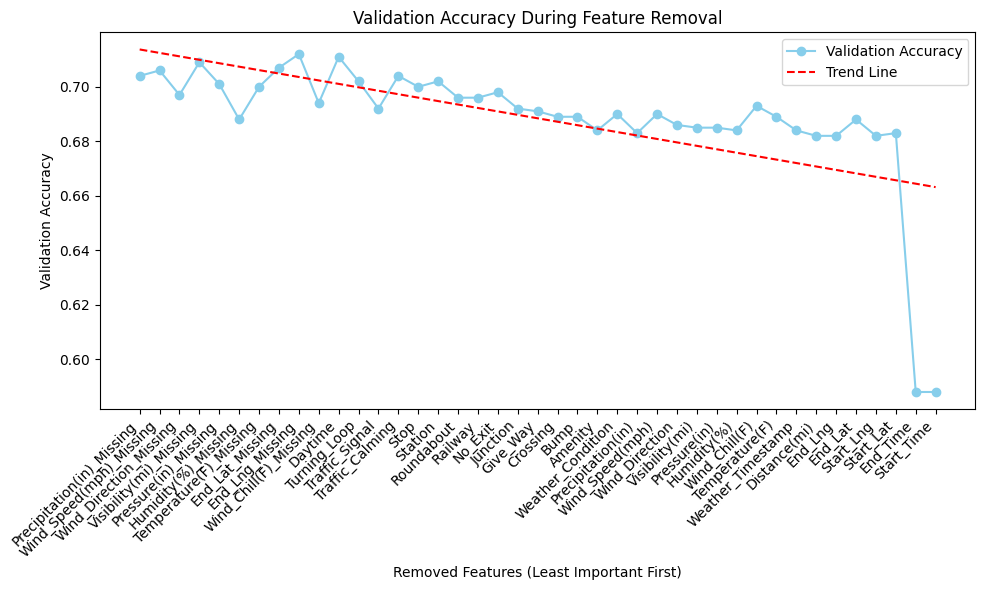

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(iterative_accuracies)), iterative_accuracies, marker='o', color='skyblue', label='Validation Accuracy')

# Plot trend line using numpy polyfit
z = np.polyfit(range(len(iterative_accuracies)), iterative_accuracies, 1)
p = np.poly1d(z)
plt.plot(range(len(iterative_accuracies)), p(range(len(iterative_accuracies))), linestyle='--', color='red', label='Trend Line')

plt.xticks(range(len(removed_features)), labels=removed_features, rotation=45, ha='right')
plt.xlabel("Removed Features (Least Important First)")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy During Feature Removal")
plt.legend()
plt.tight_layout()
plt.show()

In [1]:
 %%shell
 jupyter nbconvert --to html "/content/drive/MyDrive/Final Project/Phase 4/Phase 4.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Final Project/Phase 4/Phase 4.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 880553 bytes to /content/drive/MyDrive/Final Project/Phase 4/Phase 4.html
